#Before we start 

This notebook was created using Google Colab, with Version 5.10.147+ of the platform and Python Version 3.9.16. Any additional packages installed in this notebook are compatible with these versions.

In [ ]:
pip install geopandas 

In [ ]:
pip install contextily

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import requests
import os
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import numpy as np

#Task 1: Data Download

Bonus 1: Allow different values to be passed as parameters through command line interface when running the script.

Note : The parameter selected for this run is to: agency = 'HPD'.

Note : <br>For this data challenge, the number of rows downloaded is capped at 50,000 records, which makes it easier to rerun the analysis and fix any potential issues. 
<br>In this demonstration, the parameter is set to 'agency = HPD'.

In [4]:
from datetime import datetime
# Get agency value from user input
agency = input("Enter agency value: ")

# Set API endpoint URL
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

# Set query parameters
query_params = {
    "$limit": 50000,
    "$where": "created_date >= '{}' and agency = '{}'".format((datetime.now() - timedelta(days=7)).strftime('%Y-%m-%dT%H:%M:%S'), agency)
}

# Make API request
response = requests.get(url, params=query_params)

# Convert JSON response to pandas DataFrame
df = pd.read_json(response.text)

# Create 'data' folder if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

Enter agency value: HPD


Store dataframe to 'data' folder.

In [5]:
df.to_csv("data/raw.csv", index=False)

A quick loof of raw.csv: 

In [6]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,closed_date
0,57217592,2023-04-03T23:55:54.000,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,MOLD,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
1,57217587,2023-04-03T23:55:54.000,HPD,Department of Housing Preservation and Develop...,WATER LEAK,HEAVY FLOW,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
2,57219780,2023-04-03T23:55:53.000,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
3,57219154,2023-04-03T23:55:53.000,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN
4,57213772,2023-04-03T23:55:53.000,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10456,1195 BOSTON ROAD,BOSTON ROAD,...,BRONX,1011177,241394,PHONE,Unspecified,BRONX,40.829205,-73.9027,"{'latitude': '40.8292051835461', 'longitude': ...",NaN


#Task 2: Data Aggregation via Python

In [7]:
# Read CSV file into pandas DataFrame
df = pd.read_csv("data/raw.csv")

# Convert created_date column to datetime
df['created_date'] = pd.to_datetime(df['created_date'])

# Create new columns for date and hour
df['created_date_hour'] = df['created_date'].dt.floor('h')
df['complaint_type'] = df['complaint_type'].str.strip()

# Group by created_date_hour and complaint_type, and count the number of complaints
ts_df = df.groupby(['created_date_hour', 'complaint_type']).size().reset_index(name='count')

Store dataframe to 'data' folder.

In [8]:
ts_df.to_csv("data/time_series.csv", index=False)

A quick loof of time_series.csv: 

In [9]:
ts_df.head()

,created_date_hour,complaint_type,count
0,2023-03-29 05:00:00,HEAT/HOT WATER,11
1,2023-03-29 05:00:00,PAINT/PLASTER,2
2,2023-03-29 05:00:00,PLUMBING,1
3,2023-03-29 05:00:00,UNSANITARY CONDITION,1
4,2023-03-29 06:00:00,DOOR/WINDOW,5


#Task 3: Data Visualization via Python

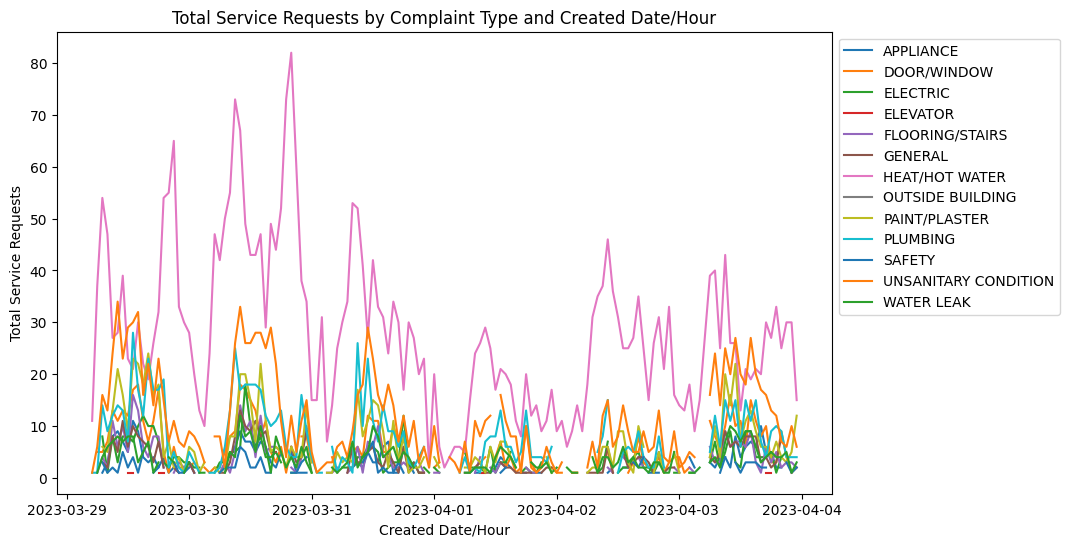

In [10]:
# Convert created_date_hour column to datetime
ts_df['created_date_hour'] = pd.to_datetime(ts_df['created_date_hour'])

# Pivot DataFrame to wide format
pivot_df = ts_df.pivot(index='created_date_hour', columns='complaint_type', values='count')

# Create multi-line plot
plt.figure(figsize=(10, 6))
plt.title("Total Service Requests by Complaint Type and Created Date/Hour")
plt.xlabel("Created Date/Hour")
plt.ylabel("Total Service Requests")
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

Store this image to 'data' folder as a .png file.

In [11]:
plt.savefig("data/service_requests.png")

<Figure size 640x480 with 0 Axes>

#Task4 : Spatial data processing via Python

Requst 2020 NTA (Neighborhood Tabulation Area) boundaries

In [12]:
url = "https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=GeoJSON"

# Make HTTP request
response = requests.get(url)

# Save GeoJSON file to 'data' folder
with open("data/nta.geojson", "wb") as f:
    f.write(response.content)

Read GeoJSON file into geopandas DataFrame.


In [13]:
nta_gdf = gpd.read_file("data/nta.geojson")

Perform spatial data processing.

In [14]:
import geopandas as gpd
from shapely.geometry import Point, MultiPoint

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(nta_gdf, geometry=gpd.points_from_xy(nta_gdf['lon'], nta_gdf['lat']))

# Group by 'ntacode' and aggregate the geometry column
grouped_gdf = gdf.groupby('ntacode')['geometry'].apply(lambda x: MultiPoint(list(x))).reset_index()

# Convert the aggregated points to polygons
grouped_gdf['geometry'] = grouped_gdf['geometry'].apply(lambda x: x.convex_hull)

# Set the CRS of the GeoDataFrame
grouped_gdf.crs = gdf.crs

In [15]:
grouped_gdf

,ntacode,geometry
0,BK09,"POLYGON ((-73.99194 40.68991, -73.99208 40.689..."
1,BK17,"POLYGON ((-73.94698 40.57610, -73.95543 40.587..."
2,BK19,POINT (-73.96677 40.57611)
3,BK21,"POLYGON ((-73.98604 40.57266, -73.98606 40.576..."
4,BK25,POINT (-73.96060 40.59524)
...,...,...
173,SI35,POINT (-74.11482 40.63451)
174,SI36,"POLYGON ((-74.08601 40.57231, -74.10001 40.579..."
175,SI37,"POLYGON ((-74.07785 40.62624, -74.07676 40.637..."
176,SI45,"POLYGON ((-74.09064 40.56837, -74.10966 40.570..."


In [16]:
geom_types = grouped_gdf.geometry.geom_type.unique()
print(geom_types)

['Polygon' 'Point' 'LineString']


To check if all the ntacode are transformed. 

In [17]:
unique_values, counts = np.unique(nta_gdf.ntacode, return_counts=True)
count = len(unique_values)
print(count)

178


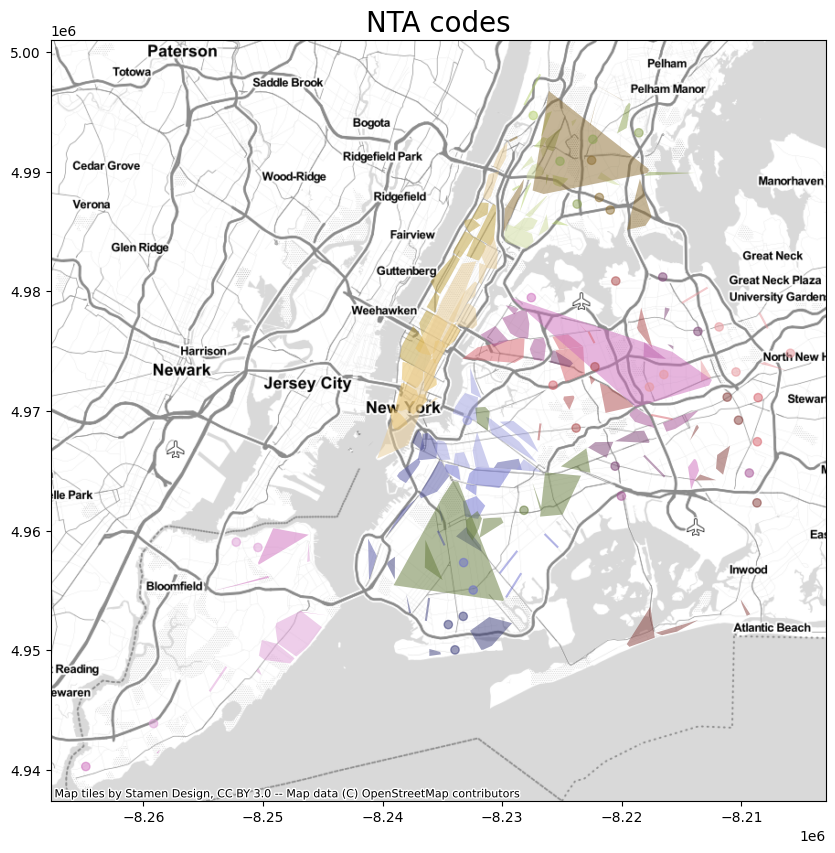

In [18]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt


# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
grouped_gdf_plt = grouped_gdf.to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with transparent colors
grouped_gdf_plt.plot(column='ntacode', cmap='tab20b', alpha=0.5, ax=ax)

# Add the base map
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

# Set the title of the plot
ax.set_title('NTA codes', fontdict={'fontsize': '20', 'fontweight': '3'})

# Show the plot
plt.show()

Finding:

Aggregating the points with the same ntacode to enclose the area is an intuitive approach, and it allows for a spatial merge to be performed to combine sample_311 points within each ntacode area. However, upon examining the resulting plot, it is evident that some ntacodes are still represented as points (with only one point per ntacode), and some enclosed areas overlap with each other. As an associate data engineer, it is important to address this data quality issue with the team and consider reaching out to the NYC Planning office for further assistance.